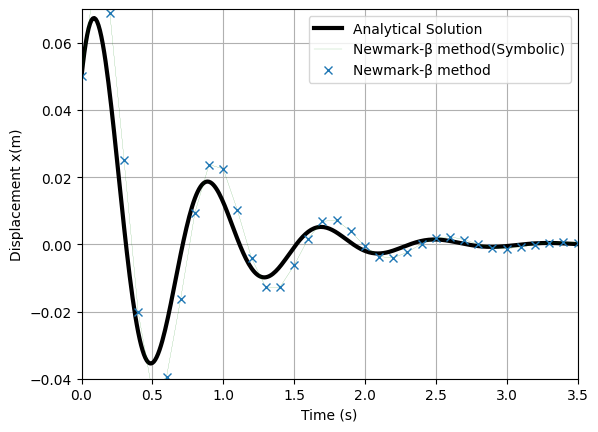

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

cSimSettings = {
    "SIM_START": 0.0,
    "SIM_END": 5.0,
    "SIM_STEP": 0.01,
}

cMdlParams = {
    "M": 5.0,
    "C": 16.0,
    "K": 320.0,
    "X0": 0.05,  # 初期変位
    "V0": 0.4,  # 初期速度
    "A0": 0.0,
    "F": 0.0,
}

cNewmarkParams = {"BETA": 1.0 / 6.0}


def calcAnalyticalSolution(t):
    # モデルパラメータ設定
    m = cMdlParams["M"]
    c = cMdlParams["C"]
    k = cMdlParams["K"]
    v0 = cMdlParams["V0"]
    x0 = cMdlParams["X0"]
    # 振動パラメータ計算
    wn = np.sqrt(k / m)  # 不減衰固有角振動数
    zeta = c / (2.0 * np.sqrt(m * k))  # 減衰比
    wd = np.sqrt(1 - zeta**2) * wn  # 減衰固有角振動数
    # 解の計算
    Amp = np.sqrt((x0**2 + ((zeta * wn * x0 + v0) / wd) ** 2))
    phi = np.arctan((zeta * wn * x0 + v0) / (x0 * wd))
    x = Amp * np.exp(-zeta * wn * t) * np.cos(wd * t - phi)
    return x


def definiteSolverNewmarkBeta():
    # 代数計算用シンボル定義
    m, c, k = sp.symbols("m, c, k")
    an, vn, xn = sp.symbols("an, vn, xn")
    an1, vn1, xn1, fn1 = sp.symbols("an1, vn1, xn1, fn1")
    dt, beta = sp.symbols("dt, beta")

    # (t+Δt)時点で満たすべき1次元振動モデルの運動方程式の定義
    eqm = m * an1 + c * vn1 + k * xn1 - fn1
    eqm = sp.lambdify((vn1, xn1), eqm, "numpy")  # 速度と位置を変数化

    # 速度と位置の数値積分式の定義
    vn1 = vn + dt * (an + an1) / 2
    xn1 = xn + dt * vn + dt**2 / 2 * an + beta * dt**2 * (an1 - an)

    # 運動方程式に代入して加速度について解く
    fan1 = eqm(vn1, xn1)
    fan1 = sp.solve(fan1, an1)[
        0
    ]  # 配列形式となって返ってきたため要素を取り出すために[0]を追加

    # 加速度、速度、位置の計算関数化
    an1_solver = sp.lambdify((m, c, k, xn, vn, an, fn1, dt, beta), fan1, "numpy")
    vn1_solver = sp.lambdify((vn, an, an1, dt), vn1, "numpy")
    xn1_solver = sp.lambdify((xn, vn, an, an1, dt, beta), xn1, "numpy")

    return (an1_solver, vn1_solver, xn1_solver)


def solverNewmarkBeta(m, c, k, xn, vn, an, fn1, dt, beta):
    an1_num = (
        fn1
        - c * (vn + dt * an / 2.0)
        - k * (xn + dt * vn + (1.0 / 2.0 - beta) * (dt**2) * an)
    )
    an1_den = m + dt * c / 2.0 + beta * (dt**2) * k
    an1 = an1_num / an1_den
    vn1 = vn + dt * (an + an1) / 2.0
    xn1 = xn + dt * vn + (dt**2) * an / 2.0 + beta * (dt**2) * (an1 - an)
    return (an1, vn1, xn1)


if __name__ == "__main__":
    # 変数準備(固定ステップで計算するためあらかじめ用意しておく)
    sim_start = cSimSettings["SIM_START"]
    sim_end = cSimSettings["SIM_END"]
    sim_step = cSimSettings["SIM_STEP"]
    num_step = int((sim_end - sim_start) / sim_step) + 1
    t = np.linspace(sim_start, sim_end, num_step)

    # 数値計算の格納結果
    a_nms = np.zeros(num_step)
    v_nms = np.zeros(num_step)
    x_nms = np.zeros(num_step)
    a_nm = np.zeros(num_step)
    v_nm = np.zeros(num_step)
    x_nm = np.zeros(num_step)

    # 解析解の計算
    num_step = int((sim_end - sim_start) / 0.01) + 1
    ta = np.linspace(sim_start, sim_end, num_step)
    x = calcAnalyticalSolution(ta)

    # 数値計算による解
    a0 = cMdlParams["A0"]
    v0 = cMdlParams["V0"]
    x0 = cMdlParams["X0"]
    m = cMdlParams["M"]
    c = cMdlParams["C"]
    k = cMdlParams["K"]
    f = cMdlParams["F"]
    dt = sim_step
    b = cNewmarkParams["BETA"]
    calc_an1, calc_vn1, calc_xn1 = definiteSolverNewmarkBeta()
    for i in range(t.size):
        if i < 1:
            # 初期値
            [a_nms[i], v_nms[i], x_nms[i]] = [a0, v0, x0]
            [a_nm[i], v_nm[i], x_nm[i]] = [a0, v0, x0]
        else:
            # シンボル計算で作成したニューマークβ法による計算
            a_nms[i] = calc_an1(
                m, c, k, x_nms[i - 1], v_nms[i - 1], a_nms[i - 1], f, dt, b
            )
            v_nms[i] = calc_vn1(v_nms[i - 1], a_nms[i - 1], a_nms[i], dt)
            x_nms[i] = calc_xn1(
                x_nms[i - 1], v_nms[i - 1], a_nms[i - 1], a_nms[i], dt, b
            )
            # ニューマークβ法による計算
            a_nm[i], v_nm[i], x_nm[i] = solverNewmarkBeta(
                m, c, k, x_nm[i - 1], v_nm[i - 1], a_nm[i - 1], f, dt, b
            )

    # グラフ確認
    plt.plot(ta, x, "k", lw=3.0, label="Analytical Solution")
    plt.plot(t, x_nms, "g", lw=0.1, label="Newmark-β method(Symbolic)")
    plt.plot(t, x_nm, "x", label="Newmark-β method")
    plt.xlim(0, 3.5)
    plt.ylim(-0.04, 0.07)
    plt.xlabel("Time (s)")
    plt.ylabel("Displacement x(m)")
    plt.legend()
    plt.grid()
    plt.show()
    # plt.savefig("./1dofVibSim_Newmarkbeta.png")